In [1]:
### REMOVE LATER ###
# Go up one directory since notebook inside task3/ folder.
import os

try:
    if UP_DIR:
        print("skipping")
except NameError:
    os.chdir("..")
    UP_DIR = True

# JH's Task 3 Experiment 2
(NOTE: keep this H1 header block or add it later to denote the boundaries between notebooks when we combined later)

Attempting Hyperparameter Sweep using Optuna.

## Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from copy import deepcopy
from task3.exp2 import Hparams, tfidf_to_np, train, inference

## Hyperparameters

In [3]:
TRAIN_CSV = "./data/train.csv"
TRAIN_TFIDF_CSV = "./data/train_tfidf_features.csv"
TEST_CSV = "./data/test.csv"
TEST_TFIDF_CSV = "./data/test_tfidf_features.csv"
HP = Hparams()

## Data Engineering
Instead of using the tfidf features given in the comp, we can engineer our own tfidf features with better filtering logic, or using something other than tfidf altogether to arrive at vector representations, or perhaps even use a strategy that use non-vector representations.

### Load Data

In [4]:
# train_df = pd.read_csv(TRAIN_CSV, index_col="id")
train_tfidf_df = pd.read_csv(TRAIN_TFIDF_CSV, index_col="id")
# test_df = pd.read_csv(TEST_CSV, index_col="id")
test_tfidf_df = pd.read_csv(TEST_TFIDF_CSV, index_col="id")

In [5]:
train_X, val_X, train_y, val_y = train_test_split(
    *tfidf_to_np(train_tfidf_df), test_size=HP.val_split, random_state=HP.seed
)
test_X, test_y = tfidf_to_np(test_tfidf_df)

print("Dataset splits:")
print("  train:", len(train_X))
print("  val:  ", len(val_X))
print("  test: ", len(test_X))

Dataset splits:
  train: 13747
  val:   3437
  test:  4296


## Optuna Hyperparameter Optimization
Setting up hyperparameter search using Optuna to find optimal parameters for our XGBoost + PCA pipeline.

In [7]:
def objective(trial):
    """Objective function for Optuna optimization."""

    # Create a copy of base hyperparameters
    hp = deepcopy(HP)

    hp.pca_n_components = trial.suggest_int("pca_n_components", 200, 800, step=100)
    hp.xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 8)
    hp.xgb_learning_rate = trial.suggest_float(
        "xgb_learning_rate", 0.005, 0.1, log=True
    )
    hp.xgb_subsample = trial.suggest_float("xgb_subsample", 0.5, 1.0)
    hp.xgb_colsample_bynode = trial.suggest_float("xgb_colsample_bynode", 0.4, 0.8)
    hp.xgb_min_child_weight = trial.suggest_float("xgb_min_child_weight", 1.0, 5.0)
    hp.xgb_min_split_loss = trial.suggest_float("xgb_min_split_loss", 0.0, 1.0)
    hp.xgb_lambda = trial.suggest_float("xgb_lambda", 0.5, 4.0)
    hp.xgb_alpha = trial.suggest_float("xgb_alpha", 0.0, 2.0)

    try:
        # Train model with suggested hyperparameters
        results = train(hp, train_X=train_X, train_y=train_y, val_X=val_X, val_y=val_y, quiet=True)

        # Store results
        trial.set_user_attr("model_xgb", results["model_xgb"])
        trial.set_user_attr("model_pca", results["model_pca"])
        trial.set_user_attr("hyperparameters", hp)

        # Return val error
        return results["val_err"]

    except Exception as e:
        print(f"Trial failed with error: {e}")
        # Return high value for failed trials
        return 1.0

In [8]:
study = optuna.create_study(
    direction="minimize",  # Minimize val error
    # Use TPE sampler for reproducibility
    sampler=optuna.samplers.TPESampler(seed=HP.seed),
)

study.optimize(objective, timeout=60*30, show_progress_bar=True)

print(f"Best validation error: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-08-09 21:57:17,450] A new study created in memory with name: no-name-54903d45-2c0f-48ff-9e99-5f1df5c2fa82


   0%|          | 00:00/30:00

[I 2025-08-09 21:57:36,137] Trial 0 finished with value: 0.28047716031422754 and parameters: {'pca_n_components': 400, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.044803926826840625, 'xgb_subsample': 0.7993292420985183, 'xgb_colsample_bynode': 0.46240745617697465, 'xgb_min_child_weight': 1.6239780813448106, 'xgb_min_split_loss': 0.05808361216819946, 'xgb_lambda': 3.531616510212273, 'xgb_alpha': 1.2022300234864176}. Best is trial 0 with value: 0.28047716031422754.
[I 2025-08-09 21:57:44,351] Trial 1 finished with value: 0.28716904276985744 and parameters: {'pca_n_components': 600, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.09138013915892866, 'xgb_subsample': 0.9162213204002109, 'xgb_colsample_bynode': 0.4849356442713105, 'xgb_min_child_weight': 1.7272998688284025, 'xgb_min_split_loss': 0.18340450985343382, 'xgb_lambda': 1.564847850358382, 'xgb_alpha': 1.0495128632644757}. Best is trial 0 with value: 0.28047716031422754.
[I 2025-08-09 21:57:44,351] Trial 1 finished with value: 0.287169042

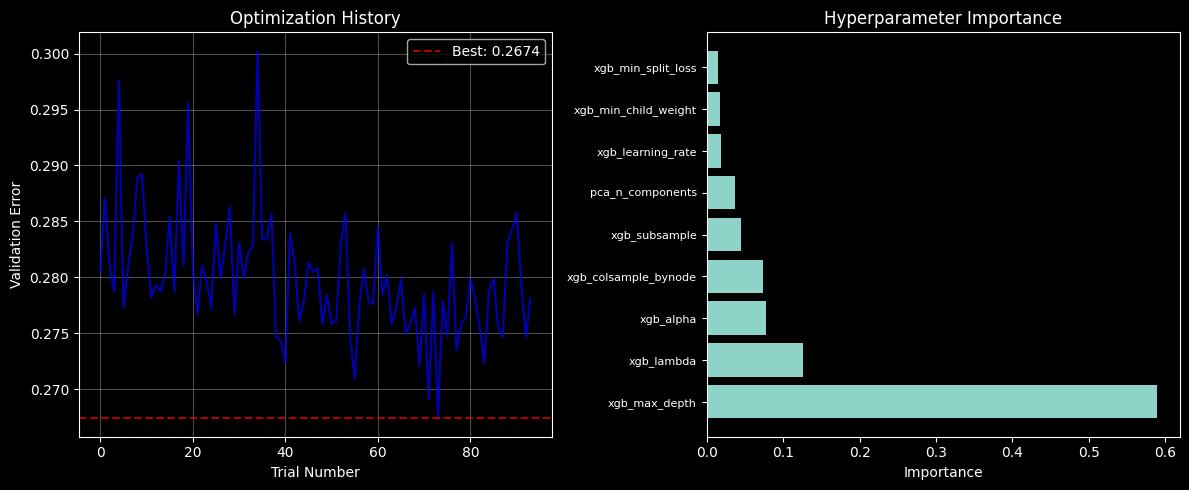

\nBest Trial Details:
Trial number: 73
Validation error: 0.2674
Parameters:
  pca_n_components: 700
  xgb_max_depth: 6
  xgb_learning_rate: 0.03356425265333407
  xgb_subsample: 0.7800054324481895
  xgb_colsample_bynode: 0.7989480375883622
  xgb_min_child_weight: 1.3241749045425868
  xgb_min_split_loss: 0.3726742969839231
  xgb_lambda: 2.683695009379512
  xgb_alpha: 0.29109756601946135


In [9]:
# Analyze optimization results
import matplotlib.pyplot as plt

# Plot optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Optimization history
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials if trial.value is not None]
trial_nums_valid = [trial.number for trial in study.trials if trial.value is not None]

ax1.plot(trial_nums_valid, trial_values, "b-", alpha=0.7)
ax1.axhline(
    y=min(trial_values),
    color="r",
    linestyle="--",
    alpha=0.7,
    label=f"Best: {min(trial_values):.4f}",
)
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("Validation Error")
ax1.set_title("Optimization History")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Parameter importance (if enough trials)
importance = optuna.importance.get_param_importances(study)
params = list(importance.keys())
values = list(importance.values())

ax2.barh(params, values)
ax2.set_xlabel("Importance")
ax2.set_title("Hyperparameter Importance")
ax2.tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.show()

# Show best trial details
print("\\nBest Trial Details:")
print(f"Trial number: {study.best_trial.number}")
print(f"Validation error: {study.best_trial.value:.4f}")
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

In [10]:
best_trial = study.best_trial
best_results = {
    "model_xgb": best_trial.user_attrs["model_xgb"],
    "model_pca": best_trial.user_attrs["model_pca"],
    "val_err": best_trial.value,
}
best_hp = best_trial.user_attrs["hyperparameters"]

print(f"Best model validation error: {best_results['val_err']:.4f}")
print("Optimal hyperparameters:")
print(f"  PCA components: {best_hp.pca_n_components}")
print(f"  XGBoost max_depth: {best_hp.xgb_max_depth}")
print(f"  XGBoost learning_rate: {best_hp.xgb_learning_rate:.4f}")
print(f"  XGBoost subsample: {best_hp.xgb_subsample:.3f}")
print(f"  XGBoost colsample_bynode: {best_hp.xgb_colsample_bynode:.3f}")
print(f"  XGBoost min_child_weight: {best_hp.xgb_min_child_weight:.2f}")
print(f"  XGBoost min_split_loss: {best_hp.xgb_min_split_loss:.3f}")
print(f"  XGBoost lambda: {best_hp.xgb_lambda:.3f}")
print(f"  XGBoost alpha: {best_hp.xgb_alpha:.3f}")

Best model validation error: 0.2674
Optimal hyperparameters:
  PCA components: 700
  XGBoost max_depth: 6
  XGBoost learning_rate: 0.0336
  XGBoost subsample: 0.780
  XGBoost colsample_bynode: 0.799
  XGBoost min_child_weight: 1.32
  XGBoost min_split_loss: 0.373
  XGBoost lambda: 2.684
  XGBoost alpha: 0.291


## Inference with Optimized Model
Using the best hyperparameters found by Optuna optimization.

In [11]:
pred_y = inference(
    test_X, model_xgb=best_results["model_xgb"], model_pca=best_results["model_pca"]
)

In [12]:
from datetime import datetime

pred_df = pd.DataFrame(
    zip(test_tfidf_df.index, np.where(pred_y > 0.5, 1, 0)), columns=["row ID", "label"]
)
# YYYYMMDD-HHMM-optuna.csv
pred_df.to_csv(f"{datetime.now().strftime('%Y%m%d-%H%M')}-optuna.csv", index=False)